In [1]:
import sys
import os

sys.path.append(os.path.abspath('..')) 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [3]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
from src.modeling.utils import (
    scale_features,
    split_by_engines,
    get_xy,
    train_and_evaluate,
    save_model
)

# Auto-reload
%load_ext autoreload
%autoreload 2
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Setup complete!")

✅ Setup complete!


In [5]:
# Load featured data
df_train_features = pd.read_csv("../data/processed/train_features.csv")
df_test_features = pd.read_csv("../data/processed/test_features.csv")

print("Loaded data:")
print(f"  Train: {df_train_features.shape}")
print(f"  Test:  {df_test_features.shape}")

# Scale features
df_train_scaled, scaler = scale_features(df_train_features, is_fit=True)
df_test_scaled, _ = scale_features(df_test_features, scaler=scaler, is_fit=False)

# Split train into train/validation by engines
df_train_split, df_val_split = split_by_engines(
    df_train_scaled,
    train_engines=70,
    val_engines=15
)

# Extract X, y
X_train, y_train = get_xy(df_train_split)
X_val, y_val = get_xy(df_val_split)

# For test: Filter to last cycle per engine (100 engines, so 100 rows)
df_test_last = df_test_scaled.groupby('engine_number').last().reset_index()
X_test_last, _ = get_xy(df_test_last)  # No y for test

# Load true test RUL (one per engine)
rul_test = pd.read_csv("../data/raw/RUL_FD001.txt", header=None, names=['true_RUL'])

print("\n")
print("DATA READY FOR MODELING")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")
print(f"X_test_last: {X_test_last.shape} (last cycle per engine)")
assert X_test_last.shape[0] == 100, "Test last cycles should be 100 rows!"


Loaded data:
  Train: (20331, 94)
  Test:  (12796, 93)
✅ Fitted scaler on 91 feature columns
   Mean (before scaling): -0.0000
   Std (before scaling):  1.0000
   After scaling: mean ≈ 0, std ≈ 1
✅ Transformed 91 feature columns using provided scaler
TRAIN/VALIDATION SPLIT BY ENGINES
Total engines available: 100

Train split:
  Engines: 70 (IDs: 1-70)
  Rows: 13,920

Validation split:
  Engines: 15 (IDs: 71-85)
  Rows: 3,165

Held-out engines: 15
📊 Extracted features and target:
   X shape: (13920, 91)
   y shape: (13920,)
   y range: [0.0, 130.0]
📊 Extracted features and target:
   X shape: (3165, 91)
   y shape: (3165,)
   y range: [0.0, 130.0]
ℹ️  No target column (RUL_capped) found - returning X only
📊 Extracted features and target:
   X shape: (100, 91)


DATA READY FOR MODELING
X_train: (13920, 91)
y_train: (13920,)
X_val:   (3165, 91)
y_val:   (3165,)
X_test_last: (100, 91) (last cycle per engine)


In [6]:

print("MODEL 1: LINEAR REGRESSION (Baseline)")


# Create model
lr_model = LinearRegression()

# Train and evaluate
print("\nTraining Linear Regression...")
lr_model.fit(X_train, y_train)
print("✅ Model trained!")

# Predict on validation
y_pred_lr_val = lr_model.predict(X_val)

# Calculate metrics (RMSE manually to avoid 'squared' argument issues)
lr_rmse = np.sqrt(mean_squared_error(y_val, y_pred_lr_val))
lr_mae = mean_absolute_error(y_val, y_pred_lr_val)
lr_r2 = r2_score(y_val, y_pred_lr_val)

print(f"\n📊 Linear Regression - Validation Results:")
print(f"   RMSE: {lr_rmse:.2f} cycles")
print(f"   MAE:  {lr_mae:.2f} cycles")
print(f"   R²:   {lr_r2:.4f}")


# Store results
lr_results = {
    'model': 'Linear Regression',
    'rmse': lr_rmse,
    'mae': lr_mae,
    'r2': lr_r2,
    'predictions': y_pred_lr_val
}

MODEL 1: LINEAR REGRESSION (Baseline)

Training Linear Regression...
✅ Model trained!

📊 Linear Regression - Validation Results:
   RMSE: 21.43 cycles
   MAE:  17.80 cycles
   R²:   0.7560


✅ Saved: figures/model_lr_predictions.png


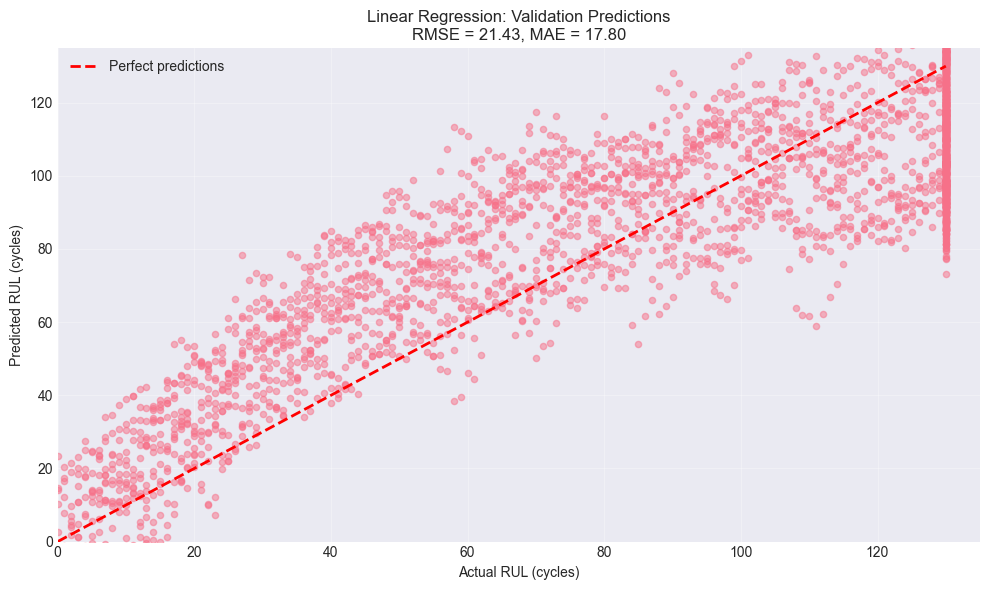

In [7]:
# Scatter plot: predicted vs actual
plt.figure(figsize=(10, 6))

plt.scatter(y_val, y_pred_lr_val, alpha=0.5, s=20)
plt.plot([0, 130], [0, 130], 'r--', linewidth=2, label='Perfect predictions')
plt.xlabel('Actual RUL (cycles)')
plt.ylabel('Predicted RUL (cycles)')
plt.title(f'Linear Regression: Validation Predictions\nRMSE = {lr_rmse:.2f}, MAE = {lr_mae:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 135)
plt.ylim(0, 135)

plt.tight_layout()
plt.savefig('../figures/model_lr_predictions.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/model_lr_predictions.png")
plt.show()

In [8]:
print("MODEL 2: RIDGE REGRESSION")

# Step 1: Train default Ridge as baseline
ridge_default = Ridge(random_state=42)
ridge_default.fit(X_train, y_train)

# Predict on validation
y_pred_ridge_default = ridge_default.predict(X_val)

# Metrics
ridge_default_rmse = np.sqrt(mean_squared_error(y_val, y_pred_ridge_default))
ridge_default_mae = mean_absolute_error(y_val, y_pred_ridge_default)
ridge_default_r2 = r2_score(y_val, y_pred_ridge_default)

print(f"✅ Default Ridge - Validation Results:")
print(f"   RMSE: {ridge_default_rmse:.2f} cycles")
print(f"   MAE:  {ridge_default_mae:.2f} cycles")
print(f"   R²:   {ridge_default_r2:.4f}")

# Step 2: Tune alpha (regularization strength)
print("\nStep 2: Tuning Alpha")

best_alpha = 1.0  # Starting point
best_alpha_rmse = float('inf')

for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    model = Ridge(alpha=alpha, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"   alpha={alpha}: RMSE={rmse:.2f}")
    if rmse < best_alpha_rmse:
        best_alpha_rmse = rmse
        best_alpha = alpha

print(f"\n✅ Best Alpha: {best_alpha} (RMSE: {best_alpha_rmse:.2f})")
print("="*60)

# Step 3: Train final Ridge with best alpha
print("\nStep 3: Training final Ridge with best alpha...")
print("="*60)

ridge_model = Ridge(alpha=best_alpha, random_state=42)
ridge_model.fit(X_train, y_train)

# Predict on validation
y_pred_ridge_val = ridge_model.predict(X_val)

# Metrics
ridge_rmse = np.sqrt(mean_squared_error(y_val, y_pred_ridge_val))
ridge_mae = mean_absolute_error(y_val, y_pred_ridge_val)
ridge_r2 = r2_score(y_val, y_pred_ridge_val)

print(f"\n📊 Ridge (final) - Validation Results:")
print(f"   RMSE: {ridge_rmse:.2f} cycles")
print(f"   MAE:  {ridge_mae:.2f} cycles")
print(f"   R²:   {ridge_r2:.4f}")
print("="*60)

# Store results
ridge_results = {
    'model': 'Ridge',
    'rmse': ridge_rmse,
    'mae': ridge_mae,
    'r2': ridge_r2,
    'predictions': y_pred_ridge_val
}

MODEL 2: RIDGE REGRESSION
✅ Default Ridge - Validation Results:
   RMSE: 21.43 cycles
   MAE:  17.80 cycles
   R²:   0.7560

Step 2: Tuning Alpha
   alpha=0.001: RMSE=21.43
   alpha=0.01: RMSE=21.43
   alpha=0.1: RMSE=21.43
   alpha=1.0: RMSE=21.43
   alpha=10.0: RMSE=21.43
   alpha=100.0: RMSE=21.52

✅ Best Alpha: 10.0 (RMSE: 21.43)

Step 3: Training final Ridge with best alpha...

📊 Ridge (final) - Validation Results:
   RMSE: 21.43 cycles
   MAE:  17.80 cycles
   R²:   0.7560


✅ Saved: figures/model_ridge_predictions.png


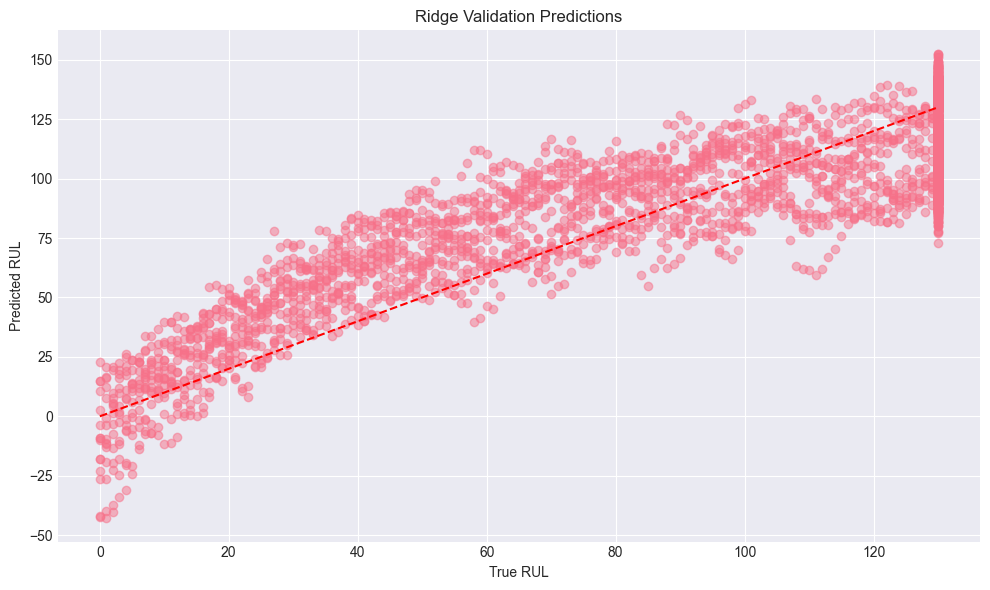

In [9]:
# Scatter plot: predicted vs actual for validation
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_ridge_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Ridge Validation Predictions')
plt.tight_layout()
plt.savefig('../figures/model_ridge_predictions.png')
print("✅ Saved: figures/model_ridge_predictions.png")
plt.show()

In [10]:

print("MODEL 2: RIDGE REGRESSION (L2 Regularization)")

# Try different alpha values
alphas = [0.1, 1, 10, 100, 1000]
ridge_results_list = []

for alpha in alphas:
    # Create model
    ridge = Ridge(alpha=alpha, random_state=42)
    
    # Train
    ridge.fit(X_train, y_train)
    
    # Predict
    y_pred = ridge.predict(X_val)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    ridge_results_list.append({
        'alpha': alpha,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred
    })
    
    print(f"Alpha={alpha:6.1f} → RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")

# Find best alpha
best_ridge = min(ridge_results_list, key=lambda x: x['rmse'])
print(f"\n✅ Best alpha: {best_ridge['alpha']} (RMSE={best_ridge['rmse']:.2f})")


MODEL 2: RIDGE REGRESSION (L2 Regularization)
Alpha=   0.1 → RMSE=21.43, MAE=17.80, R²=0.7560
Alpha=   1.0 → RMSE=21.43, MAE=17.80, R²=0.7560
Alpha=  10.0 → RMSE=21.43, MAE=17.80, R²=0.7560
Alpha= 100.0 → RMSE=21.52, MAE=17.91, R²=0.7539
Alpha=1000.0 → RMSE=21.99, MAE=18.35, R²=0.7431

✅ Best alpha: 10 (RMSE=21.43)


In [11]:
# Train Ridge with best alpha
best_alpha = best_ridge['alpha']
ridge_model = Ridge(alpha=best_alpha, random_state=42)

print(f"Training final Ridge model with alpha={best_alpha}...")
ridge_model.fit(X_train, y_train)

# Get predictions
y_pred_ridge_val = ridge_model.predict(X_val)

# Metrics
ridge_rmse = np.sqrt(mean_squared_error(y_val, y_pred_ridge_val))
ridge_mae = mean_absolute_error(y_val, y_pred_ridge_val)
ridge_r2 = r2_score(y_val, y_pred_ridge_val)

print(f"\n📊 Ridge (alpha={best_alpha}) - Validation Results:")
print(f"   RMSE: {ridge_rmse:.2f} cycles")
print(f"   MAE:  {ridge_mae:.2f} cycles")
print(f"   R²:   {ridge_r2:.4f}")

# Store results
ridge_results = {
    'model': f'Ridge (α={best_alpha})',
    'rmse': ridge_rmse,
    'mae': ridge_mae,
    'r2': ridge_r2,
    'predictions': y_pred_ridge_val
}

Training final Ridge model with alpha=10...

📊 Ridge (alpha=10) - Validation Results:
   RMSE: 21.43 cycles
   MAE:  17.80 cycles
   R²:   0.7560


✅ Saved: figures/model_ridge_tuning.png


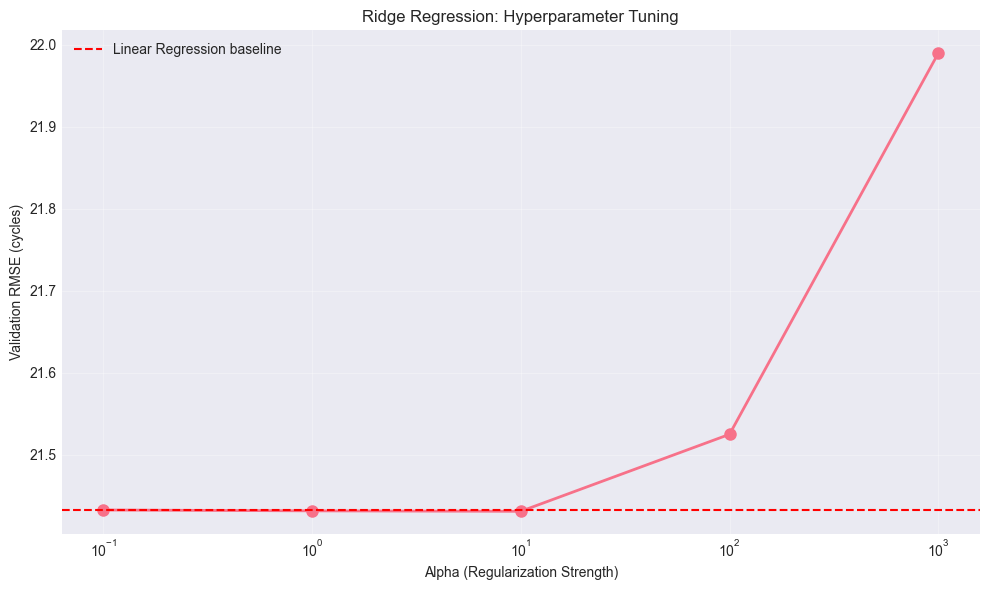

In [12]:
# Plot alpha vs RMSE
alphas_list = [r['alpha'] for r in ridge_results_list]
rmses = [r['rmse'] for r in ridge_results_list]

plt.figure(figsize=(10, 6))
plt.plot(alphas_list, rmses, marker='o', linewidth=2, markersize=8)
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Validation RMSE (cycles)')
plt.title('Ridge Regression: Hyperparameter Tuning')
plt.grid(True, alpha=0.3)
plt.axhline(lr_rmse, color='red', linestyle='--', label='Linear Regression baseline')
plt.legend()

plt.tight_layout()
plt.savefig('../figures/model_ridge_tuning.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/model_ridge_tuning.png")
plt.show()

In [13]:

print("MODEL 3: RANDOM FOREST (Ensemble)")

# Start with defaults
print("\nStep 1: Training with default parameters...")
rf_default = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_default.fit(X_train, y_train)
y_pred_rf_default = rf_default.predict(X_val)

rf_default_rmse = np.sqrt(mean_squared_error(y_val, y_pred_rf_default))
rf_default_mae = mean_absolute_error(y_val, y_pred_rf_default)
rf_default_r2 = r2_score(y_val, y_pred_rf_default)

print(f"✅ Default Random Forest - Validation Results:")
print(f"   RMSE: {rf_default_rmse:.2f} cycles")
print(f"   MAE:  {rf_default_mae:.2f} cycles")
print(f"   R²:   {rf_default_r2:.4f}")


MODEL 3: RANDOM FOREST (Ensemble)

Step 1: Training with default parameters...
✅ Default Random Forest - Validation Results:
   RMSE: 19.21 cycles
   MAE:  14.17 cycles
   R²:   0.8040


In [14]:
# Tune number of trees
print("\nStep 2: Tuning n_estimators (number of trees)...")


n_estimators_list = [100, 200, 300]
rf_estimators_results = []

for n_est in n_estimators_list:
    print(f"Training with {n_est} trees...")
    rf = RandomForestRegressor(n_estimators=n_est, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    rf_estimators_results.append({
        'n_estimators': n_est,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    })
    
    print(f"  n_estimators={n_est} → RMSE={rmse:.2f}, MAE={mae:.2f}")

best_n_est = min(rf_estimators_results, key=lambda x: x['rmse'])
print(f"\n✅ Best n_estimators: {best_n_est['n_estimators']} (RMSE={best_n_est['rmse']:.2f})")



Step 2: Tuning n_estimators (number of trees)...
Training with 100 trees...
  n_estimators=100 → RMSE=19.21, MAE=14.17
Training with 200 trees...
  n_estimators=200 → RMSE=19.15, MAE=14.13
Training with 300 trees...
  n_estimators=300 → RMSE=19.14, MAE=14.13

✅ Best n_estimators: 300 (RMSE=19.14)


In [15]:
# Tune tree depth
print("\nStep 3: Tuning max_depth (tree complexity)...")


max_depths = [10, 20, None]  # None = no limit
rf_depth_results = []

best_n_estimators = best_n_est['n_estimators']

for depth in max_depths:
    depth_str = str(depth) if depth is not None else "unlimited"
    print(f"Training with max_depth={depth_str}...")
    
    rf = RandomForestRegressor(
        n_estimators=best_n_estimators,
        max_depth=depth,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    rf_depth_results.append({
        'max_depth': depth,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    })
    
    print(f"  max_depth={depth_str} → RMSE={rmse:.2f}, MAE={mae:.2f}")

best_depth = min(rf_depth_results, key=lambda x: x['rmse'])
print(f"\n✅ Best max_depth: {best_depth['max_depth']} (RMSE={best_depth['rmse']:.2f})")



Step 3: Tuning max_depth (tree complexity)...
Training with max_depth=10...
  max_depth=10 → RMSE=18.82, MAE=13.93
Training with max_depth=20...
  max_depth=20 → RMSE=19.14, MAE=14.10
Training with max_depth=unlimited...
  max_depth=unlimited → RMSE=19.14, MAE=14.13

✅ Best max_depth: 10 (RMSE=18.82)


In [16]:
# Train final RF with best hyperparameters
print("\nStep 4: Training final Random Forest with best hyperparameters...")


best_params = {
    'n_estimators': best_n_est['n_estimators'],
    'max_depth': best_depth['max_depth'],
    'random_state': 42,
    'n_jobs': -1
}

print(f"Parameters: {best_params}")

rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train, y_train)

# Predict on validation
y_pred_rf_val = rf_model.predict(X_val)

# Metrics
rf_rmse = np.sqrt(mean_squared_error(y_val, y_pred_rf_val))
rf_mae = mean_absolute_error(y_val, y_pred_rf_val)
rf_r2 = r2_score(y_val, y_pred_rf_val)

print(f"\n📊 Random Forest (final) - Validation Results:")
print(f"   RMSE: {rf_rmse:.2f} cycles")
print(f"   MAE:  {rf_mae:.2f} cycles")
print(f"   R²:   {rf_r2:.4f}")


# Store results
rf_results = {
    'model': 'Random Forest',
    'rmse': rf_rmse,
    'mae': rf_mae,
    'r2': rf_r2,
    'predictions': y_pred_rf_val
}


Step 4: Training final Random Forest with best hyperparameters...
Parameters: {'n_estimators': 300, 'max_depth': 10, 'random_state': 42, 'n_jobs': -1}

📊 Random Forest (final) - Validation Results:
   RMSE: 18.82 cycles
   MAE:  13.93 cycles
   R²:   0.8118


✅ Saved: figures/model_rf_predictions.png


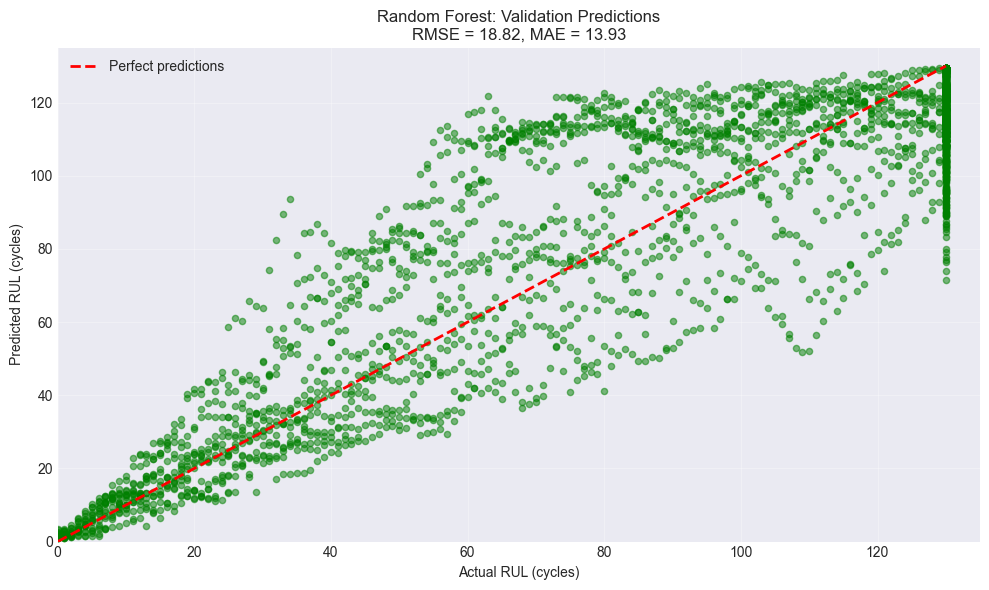

In [17]:
# Scatter plot: predicted vs actual
plt.figure(figsize=(10, 6))

plt.scatter(y_val, y_pred_rf_val, alpha=0.5, s=20, color='green')
plt.plot([0, 130], [0, 130], 'r--', linewidth=2, label='Perfect predictions')
plt.xlabel('Actual RUL (cycles)')
plt.ylabel('Predicted RUL (cycles)')
plt.title(f'Random Forest: Validation Predictions\nRMSE = {rf_rmse:.2f}, MAE = {rf_mae:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 135)
plt.ylim(0, 135)

plt.tight_layout()
plt.savefig('../figures/model_rf_predictions.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/model_rf_predictions.png")
plt.show()

In [18]:
# Create comparison table
comparison_data = {
    'Model': [lr_results['model'], ridge_results['model'], rf_results['model']],
    'Val RMSE': [lr_results['rmse'], ridge_results['rmse'], rf_results['rmse']],
    'Val MAE': [lr_results['mae'], ridge_results['mae'], rf_results['mae']],
    'Val R²': [lr_results['r2'], ridge_results['r2'], rf_results['r2']]
}

comparison_df = pd.DataFrame(comparison_data)


print("MODEL COMPARISON - VALIDATION SET")

display(comparison_df)

# Find best model
best_model_idx = comparison_df['Val RMSE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   RMSE: {comparison_df.loc[best_model_idx, 'Val RMSE']:.2f} cycles")


MODEL COMPARISON - VALIDATION SET


,Model,Val RMSE,Val MAE,Val R²
0,Linear Regression,21.432826,17.797482,0.755963
1,Ridge (α=10),21.431085,17.800834,0.756003
2,Random Forest,18.820475,13.927133,0.811827



🏆 Best Model: Random Forest
   RMSE: 18.82 cycles


✅ Saved: figures/model_comparison.png


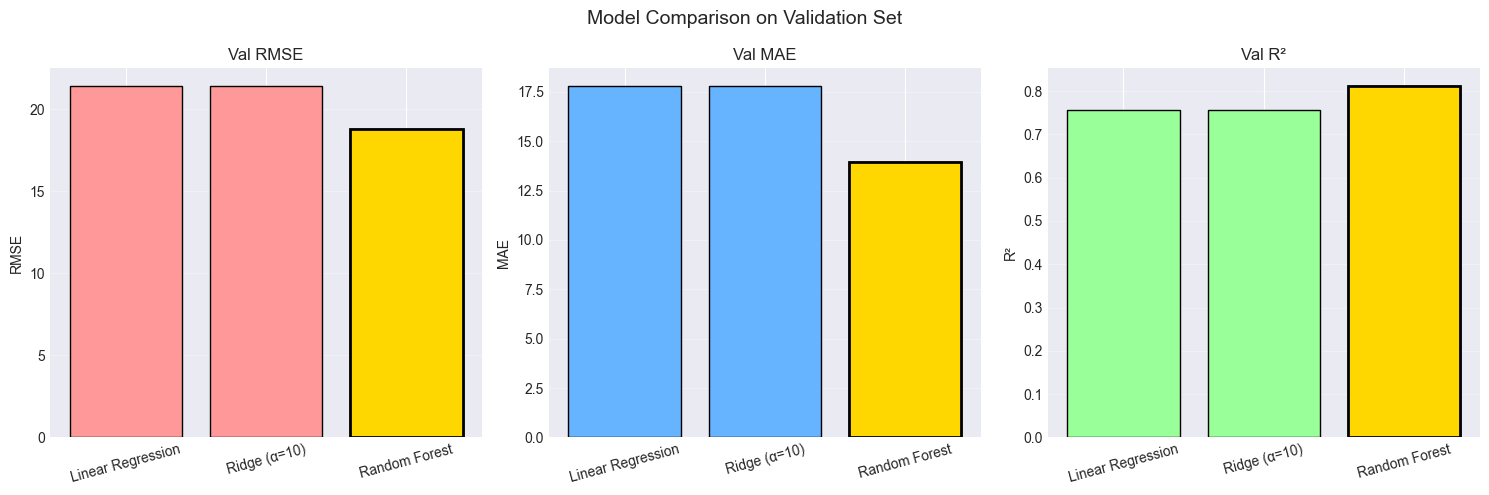

In [19]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Val RMSE', 'Val MAE', 'Val R²']
colors = ['#ff9999', '#66b3ff', '#99ff99']

for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df['Model'], comparison_df[metric], color=colors[i], edgecolor='black')
    axes[i].set_ylabel(metric.split(' ')[1])
    axes[i].set_title(metric)
    axes[i].grid(True, alpha=0.3, axis='y')
    axes[i].tick_params(axis='x', rotation=15)
    
    # Highlight best
    best_idx = comparison_df[metric].idxmin() if 'RMSE' in metric or 'MAE' in metric else comparison_df[metric].idxmax()
    axes[i].bar(comparison_df.loc[best_idx, 'Model'], comparison_df.loc[best_idx, metric], 
                color='gold', edgecolor='black', linewidth=2)

plt.suptitle('Model Comparison on Validation Set', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/model_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/model_comparison.png")
plt.show()

✅ Saved: figures/model_residuals.png


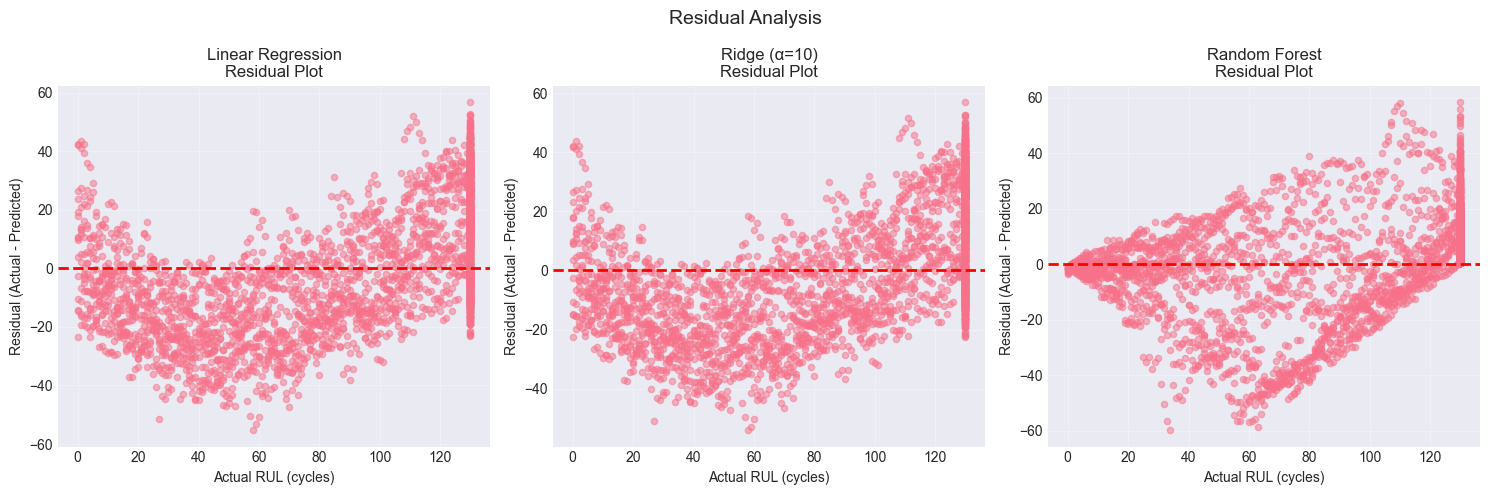


💡 Good residuals: randomly scattered around 0 with no pattern


In [20]:
# Residual plots for all models
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models_data = [
    ('Linear Regression', y_pred_lr_val),
    (f'Ridge (α={best_alpha})', y_pred_ridge_val),
    ('Random Forest', y_pred_rf_val)
]

for i, (name, y_pred) in enumerate(models_data):
    residuals = y_val - y_pred
    
    axes[i].scatter(y_val, residuals, alpha=0.5, s=20)
    axes[i].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[i].set_xlabel('Actual RUL (cycles)')
    axes[i].set_ylabel('Residual (Actual - Predicted)')
    axes[i].set_title(f'{name}\nResidual Plot')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Residual Analysis', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/model_residuals.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/model_residuals.png")
plt.show()

print("\n💡 Good residuals: randomly scattered around 0 with no pattern")

Top 20 Most Important Features:


,feature,importance
35,sensor_4_mean_10,0.362849
33,sensor_3_mean_10,0.158084
5,sensor_4_mean_5,0.118076
43,sensor_9_mean_10,0.052517
13,sensor_9_mean_5,0.052284
59,sensor_21_mean_10,0.041773
31,sensor_2_mean_10,0.037729
15,sensor_11_mean_5,0.031398
53,sensor_15_mean_10,0.017687
51,sensor_14_mean_10,0.011333



✅ Saved: figures/model_feature_importance.png


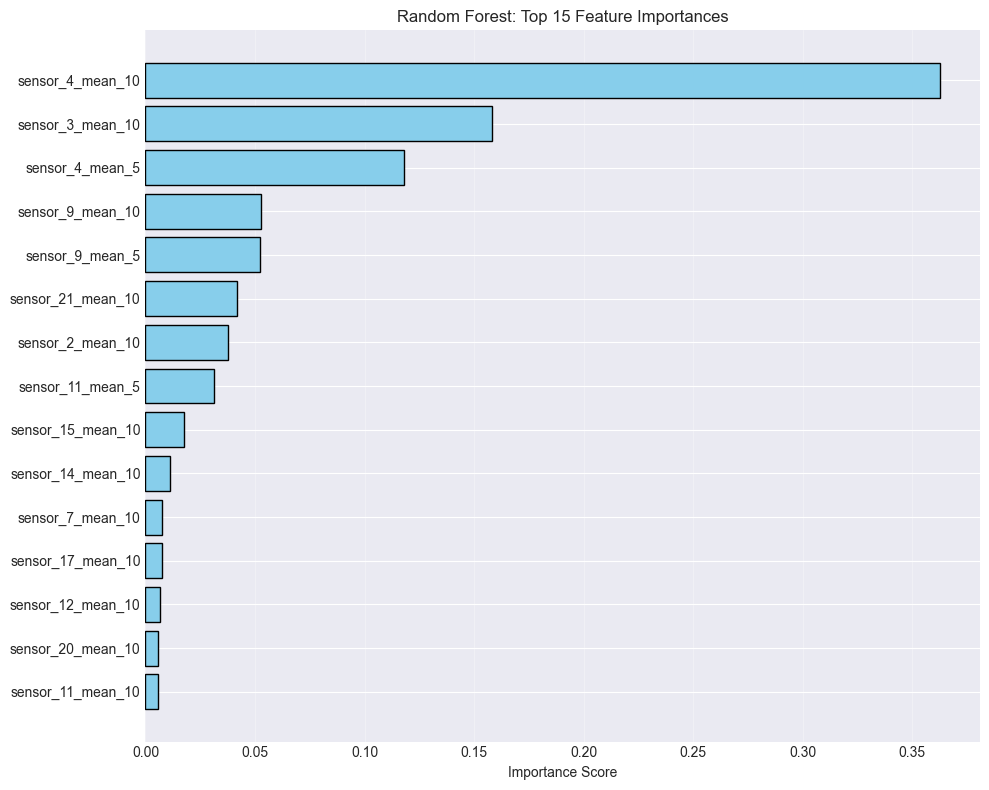

In [21]:
# Get feature importances from Random Forest
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")

display(feature_importances.head(20))

# Visualize top 15
plt.figure(figsize=(10, 8))
top_15 = feature_importances.head(15)

plt.barh(range(len(top_15)), top_15['importance'], color='skyblue', edgecolor='black')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score')
plt.title('Random Forest: Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../figures/model_feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: figures/model_feature_importance.png")
plt.show()

In [22]:

print("FINAL EVALUATION - OFFICIAL TEST SET")


# Load true RUL values from RUL_FD001.txt
rul_test_path = "../data/raw/RUL_FD001.txt"
rul_test = pd.read_csv(rul_test_path, header=None, names=['true_RUL'])

print(f"\nLoaded true RUL for test set: {rul_test.shape}")
print(f"  (One RUL value per engine at their LAST observed cycle)")

# Get last cycle of each test engine
df_test_last_cycle = df_test_scaled.groupby('engine_number').tail(1).reset_index(drop=True)
X_test_last_cycle = df_test_last_cycle[[col for col in df_test_last_cycle.columns 
                                         if col not in ['engine_number', 'cycle']]]

print(f"\nTest set - last cycle per engine: {X_test_last_cycle.shape}")
print(f"  (Should be 100 rows, one per engine)")

# Verify we have 100 engines
assert len(X_test_last_cycle) == 100, "Should have exactly 100 test engines!"
assert len(rul_test) == 100, "Should have exactly 100 true RUL values!"

# Predict with best model (Random Forest)
y_pred_test = rf_model.predict(X_test_last_cycle)

# Calculate test metrics
test_rmse = np.sqrt(mean_squared_error(rul_test['true_RUL'], y_pred_test))
test_mae = mean_absolute_error(rul_test['true_RUL'], y_pred_test)
test_r2 = r2_score(rul_test['true_RUL'], y_pred_test)

print(f"\n🎯 Random Forest - TEST SET Results:")
print(f"   RMSE: {test_rmse:.2f} cycles")
print(f"   MAE:  {test_mae:.2f} cycles")
print(f"   R²:   {test_r2:.4f}")

print(f"\n📊 Comparison:")
print(f"   Validation RMSE: {rf_rmse:.2f}")
print(f"   Test RMSE:       {test_rmse:.2f}")
print(f"   Difference:      {abs(rf_rmse - test_rmse):.2f} cycles")

if abs(rf_rmse - test_rmse) < 5:
    print(f"\n✅ Good generalization! Val and test RMSE are similar.")
else:
    print(f"\n⚠️  Some overfitting detected (val/test RMSE differ by >5 cycles)")



FINAL EVALUATION - OFFICIAL TEST SET

Loaded true RUL for test set: (100, 1)
  (One RUL value per engine at their LAST observed cycle)

Test set - last cycle per engine: (100, 91)
  (Should be 100 rows, one per engine)

🎯 Random Forest - TEST SET Results:
   RMSE: 19.70 cycles
   MAE:  14.07 cycles
   R²:   0.7752

📊 Comparison:
   Validation RMSE: 18.82
   Test RMSE:       19.70
   Difference:      0.88 cycles

✅ Good generalization! Val and test RMSE are similar.


✅ Saved: figures/model_test_predictions.png


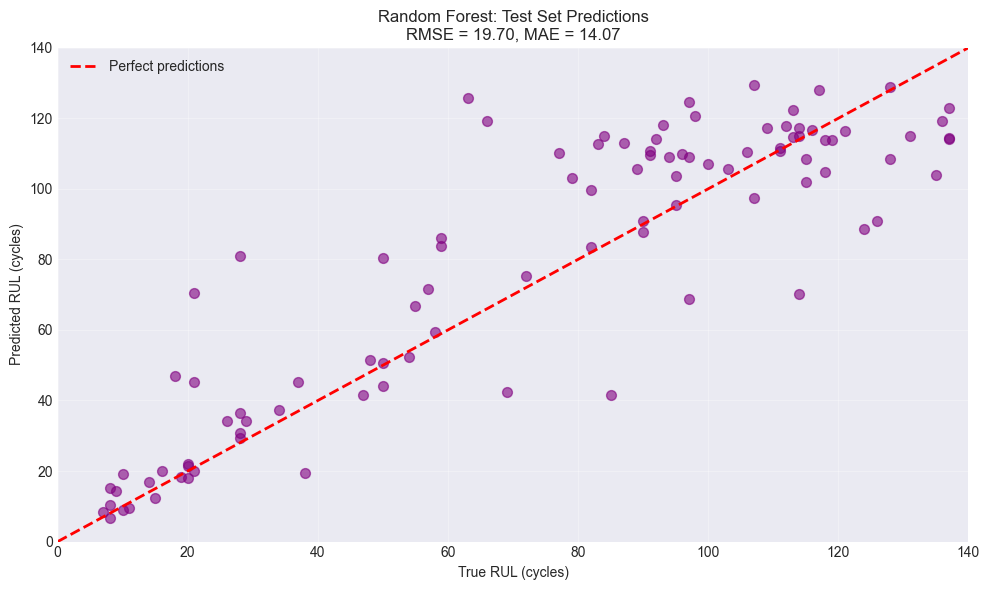

In [23]:
# Scatter plot: test predictions vs true RUL
plt.figure(figsize=(10, 6))

plt.scatter(rul_test['true_RUL'], y_pred_test, alpha=0.6, s=50, color='purple')
plt.plot([0, 140], [0, 140], 'r--', linewidth=2, label='Perfect predictions')
plt.xlabel('True RUL (cycles)')
plt.ylabel('Predicted RUL (cycles)')
plt.title(f'Random Forest: Test Set Predictions\nRMSE = {test_rmse:.2f}, MAE = {test_mae:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 140)
plt.ylim(0, 140)

plt.tight_layout()
plt.savefig('../figures/model_test_predictions.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/model_test_predictions.png")
plt.show()

In [24]:
# Save the best model (Random Forest)
model_path = "../models/rf_model.pkl"
joblib.dump(rf_model, model_path)
print(f"💾 Saved Random Forest model to: {model_path}")

# Verify it can be loaded
rf_loaded = joblib.load(model_path)
print(f"✅ Verified model can be loaded")

# Test loaded model makes same predictions
test_pred_original = rf_model.predict(X_val[:5])
test_pred_loaded = rf_loaded.predict(X_val[:5])

if np.allclose(test_pred_original, test_pred_loaded):
    print(f"✅ Loaded model produces identical predictions")
else:
    print(f"❌ ERROR: Loaded model predictions differ!")

# Also save the comparison results
results_summary = {
    'models': comparison_df.to_dict('records'),
    'best_model': best_model_name,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_r2': test_r2,
    'rf_params': best_params
}

import json
with open('../figures/model_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"💾 Saved results summary to: ../figures/model_results.json")

💾 Saved Random Forest model to: ../models/rf_model.pkl
✅ Verified model can be loaded
✅ Loaded model produces identical predictions
💾 Saved results summary to: ../figures/model_results.json


In [25]:
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd  # Ensure this is imported if not already

# ────────────────────────────────────────────────
# Make sure these variables exist and are correct
# (they should come from your earlier data preparation)
# ────────────────────────────────────────────────

# Example (adjust column names if needed):
df_train_full = pd.concat([df_train_split, df_val_split], ignore_index=True)

# IMPORTANT FIX: Explicitly drop 'RUL' here to prevent leakage
df_train_full = df_train_full.drop(columns=['RUL'], errors='ignore')  # ← ADD THIS LINE

X_full = df_train_full.drop(
    columns=['RUL_capped', 'engine_number', 'cycle'], 
    errors='ignore'
).values

y_full = df_train_full['RUL_capped'].values
groups = df_train_full['engine_number'].values

print("Sanity check before CV:")
print(f"X shape: {X_full.shape}")
print(f"y shape: {y_full.shape}")
print(f"Number of unique engines: {len(np.unique(groups))}")
print(f"Min/Max/Mean RUL: {y_full.min():.1f} / {y_full.max():.1f} / {y_full.mean():.1f}")
print(f"First 8 RUL values of engine 1: {y_full[groups == 1][:8]}")
print("-" * 60)

# ────────────────────────────────────────────────
# Grouped Cross-Validation with debug prints
# ────────────────────────────────────────────────

gkf = GroupKFold(n_splits=5)
rmse_scores_grouped = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_full, y_full, groups=groups), 1):
    print(f"\nFold {fold}")
    val_engines = np.sort(np.unique(groups[val_idx]))
    print(f"Val engines ({len(val_engines)} engines): {val_engines}")
    print(f"Val samples: {len(val_idx)}")
    
    X_tr, X_vl = X_full[train_idx], X_full[val_idx]
    y_tr, y_vl = y_full[train_idx], y_full[val_idx]
    
    # Debug: look at actual target values in this validation fold
    print(f"Val fold RUL stats → min: {y_vl.min():.1f}, max: {y_vl.max():.1f}, mean: {y_vl.mean():.1f}")
    print(f"First 6 true RUL values in val fold: {y_vl[:6]}")
    
    # Create FRESH model for each fold (very important!)
    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,              # ← use your actual best parameters here
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    rf.fit(X_tr, y_tr)
    
    # Predict ONLY on validation fold
    y_pred_vl = rf.predict(X_vl)
    
    # Debug: look at predictions
    print(f"First 6 predictions:      {y_pred_vl[:6]}")
    print(f"Difference (true - pred): {y_vl[:6] - y_pred_vl[:6]}")
    
    # Compute real error
    rmse = np.sqrt(mean_squared_error(y_vl, y_pred_vl))
    rmse_scores_grouped.append(rmse)
    
    print(f"→ Fold RMSE: {rmse:.2f}  ({len(val_idx)} samples)")
    print("-" * 50)

# Final summary
mean_rmse = np.mean(rmse_scores_grouped)
std_rmse  = np.std(rmse_scores_grouped)

print(f"\nMean Grouped CV RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}")
print(f"All fold RMSEs: {[f'{x:.2f}' for x in rmse_scores_grouped]}")

Sanity check before CV:
X shape: (17085, 91)
y shape: (17085,)
Number of unique engines: 85
Min/Max/Mean RUL: 0.0 / 130.0 / 87.6
First 8 RUL values of engine 1: [130 130 130 130 130 130 130 130]
------------------------------------------------------------

Fold 1
Val engines (17 engines): [ 4  7  8 15 19 20 25 30 34 57 61 63 68 69 72 74 82]
Val samples: 3415
Val fold RUL stats → min: 0.0, max: 130.0, mean: 87.6
First 6 true RUL values in val fold: [130 130 130 130 130 130]
First 6 predictions:      [115.4626729  112.31194511 114.43156008 114.45282333 112.87288513
 115.47562828]
Difference (true - pred): [14.5373271  17.68805489 15.56843992 15.54717667 17.12711487 14.52437172]
→ Fold RMSE: 21.30  (3415 samples)
--------------------------------------------------

Fold 2
Val engines (17 engines): [11 12 16 21 22 29 42 48 49 55 62 67 70 73 77 84 85]
Val samples: 3415
Val fold RUL stats → min: 0.0, max: 130.0, mean: 87.6
First 6 true RUL values in val fold: [130 130 130 130 130 130]
First 6

In [26]:
# INSIDE the loop — not outside!
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,           # or your best value
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_tr, y_tr)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [35]:
for fold, (train_idx, val_idx) in enumerate(gkf.split(X_full, y_full, groups), 1):
    X_tr, X_vl = X_full[train_idx], X_full[val_idx]
    y_tr, y_vl = y_full[train_idx], y_full[val_idx]
    
    print(f"Fold {fold} - val samples: {len(y_vl)}")
    print(f"First 5 true RUL in this val fold: {y_vl[:5]}")           # ← should show varied numbers 0–130
    print(f"Mean RUL in val fold: {y_vl.mean():.1f}")                 # ← should be ~50–70
    
    rf = RandomForestRegressor(
     n_estimators=200,          # number of trees — good starting point
     max_depth=15,              # limit tree depth to prevent overfitting
     min_samples_split=5,
     min_samples_leaf=2,
     random_state=42,
     n_jobs=-1                  # use all CPU cores
   )
    rf.fit(X_tr, y_tr)
    
    y_pred = rf.predict(X_vl)
    
    print(f"First 5 predictions: {y_pred[:5]}")                       # ← should NOT be all zeros or exact match to y_vl
    print(f"First 5 true vs pred:\n{y_vl[:5]}\n{y_pred[:5]}")
    
    rmse = np.sqrt(mean_squared_error(y_vl, y_pred))
    print(f"→ Fold RMSE: {rmse:.2f}\n")

Fold 1 - val samples: 3415
First 5 true RUL in this val fold: [130 130 130 130 130]
Mean RUL in val fold: 87.6
First 5 predictions: [115.4626729  112.31194511 114.43156008 114.45282333 112.87288513]
First 5 true vs pred:
[130 130 130 130 130]
[115.4626729  112.31194511 114.43156008 114.45282333 112.87288513]
→ Fold RMSE: 21.30

Fold 2 - val samples: 3415
First 5 true RUL in this val fold: [130 130 130 130 130]
Mean RUL in val fold: 87.6
First 5 predictions: [125.97077408 129.26857741 129.70645147 129.83184794 129.89735223]
First 5 true vs pred:
[130 130 130 130 130]
[125.97077408 129.26857741 129.70645147 129.83184794 129.89735223]
→ Fold RMSE: 22.87

Fold 3 - val samples: 3424
First 5 true RUL in this val fold: [130 130 130 130 130]
Mean RUL in val fold: 87.7
First 5 predictions: [129.41044064 129.32976372 129.50516626 129.43183437 129.61815254]
First 5 true vs pred:
[130 130 130 130 130]
[129.41044064 129.32976372 129.50516626 129.43183437 129.61815254]
→ Fold RMSE: 19.39

Fold 4 - v

In [ ]:
print("Test data ready check:")
print(f"X_test_last shape: {X_test_last.shape}")         
print(f"True RUL shape: {rul_test.shape}")                
print(f"First 3 true RUL values: {rul_test['true_RUL'].head(3).values}")

Test data ready check:
X_test_last shape: (100, 91)
True RUL shape: (100, 1)
First 3 true RUL values: [112  98  69]


In [51]:
print("OFFICIAL TEST SET EVALUATION (last cycle per engine)")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Function to print results nicely
def print_test_results(model_name, y_pred):
    rmse = np.sqrt(mean_squared_error(rul_test['true_RUL'], y_pred))
    mae  = mean_absolute_error(rul_test['true_RUL'], y_pred)
    r2   = r2_score(rul_test['true_RUL'], y_pred)
    print(f"{model_name}:")
    print(f"  RMSE: {rmse:.2f} cycles")
    print(f"  MAE:  {mae:.2f} cycles")
    print(f"  R²:   {r2:.4f}")
    print("-" * 40)
    return rmse, mae, r2

# Linear Regression
y_pred_lr_test = lr_model.predict(X_test_last)
print_test_results("Linear Regression", y_pred_lr_test)

# Ridge
y_pred_ridge_test = ridge_model.predict(X_test_last)  
print_test_results("Ridge", y_pred_ridge_test)

# Random Forest 
y_pred_rf_test = rf_model.predict(X_test_last)
print_test_results("Random Forest", y_pred_rf_test)


OFFICIAL TEST SET EVALUATION (last cycle per engine)
Linear Regression:
  RMSE: 21.93 cycles
  MAE:  17.54 cycles
  R²:   0.7214
----------------------------------------
Ridge:
  RMSE: 21.92 cycles
  MAE:  17.50 cycles
  R²:   0.7218
----------------------------------------
Random Forest:
  RMSE: 19.70 cycles
  MAE:  14.07 cycles
  R²:   0.7752
----------------------------------------


(19.704558542149947, 14.066292075996897, 0.7751598456878188)

In [52]:
def nasa_score(y_true, y_pred):
    diff = y_true - y_pred
    score = np.sum(np.where(diff < 0, np.exp(-diff/13) - 1, np.exp(diff/10) - 1))
    return score

# Example for Random Forest
nasa_rf = nasa_score(rul_test['true_RUL'], y_pred_rf_test)
print(f"NASA Score (Random Forest): {nasa_rf:.0f}")

NASA Score (Random Forest): 765


In [53]:
results = {
    'Model': ['Linear Regression', 'Ridge', 'Random Forest'],
    'Val RMSE': [21.43, 21.43, 18.82],
    'Val MAE':  [17.80, 17.80, 13.93],
    'Test RMSE': [21.93, 21.92, 19.70],
    'Test MAE':  [17.54, 17.50, 14.07]
}

df_compare = pd.DataFrame(results).round(2)
print("Final Model Comparison – Validation vs Test")
display(df_compare.sort_values('Test RMSE'))

Final Model Comparison – Validation vs Test


,Model,Val RMSE,Val MAE,Test RMSE,Test MAE
2,Random Forest,18.82,13.93,19.70,14.07
1,Ridge,21.43,17.80,21.92,17.50
0,Linear Regression,21.43,17.80,21.93,17.54


In [59]:
import os

# Create demo folder if not exists
os.makedirs('../data/demo', exist_ok=True)

# Choose 3 engine IDs from test set (change these IDs based on your data)
# Healthy: high RUL (>100), Warning: medium (30-70), Critical: low (<20)
demo_engines = {
    'healthy':  28,   # ← change to a real engine with high RUL
    'warning':  72,   # ← medium RUL
    'critical': 95    # ← low RUL / near failure
}

for label, engine_id in demo_engines.items():
    # Get all cycles for this engine from your processed test data
    df_engine = df_test_features[df_test_features['engine_number'] == engine_id]
    
    if df_engine.empty:
        print(f"Warning: Engine {engine_id} not found in test data!")
        continue
    
    # Save the full engine history (all cycles)
    file_path = f"../data/demo/{label}_engine_{engine_id}.csv"
    df_engine.to_csv(file_path, index=False)
    print(f"Saved: {file_path}")

Saved: ../data/demo/healthy_engine_28.csv
Saved: ../data/demo/warning_engine_72.csv
Saved: ../data/demo/critical_engine_95.csv


In [60]:
print("Copy this list into app.py:")
print(X_train.columns.tolist())

Copy this list into app.py:
['setting_1', 'sensor_2_mean_5', 'sensor_2_std_5', 'sensor_3_mean_5', 'sensor_3_std_5', 'sensor_4_mean_5', 'sensor_4_std_5', 'sensor_6_mean_5', 'sensor_6_std_5', 'sensor_7_mean_5', 'sensor_7_std_5', 'sensor_8_mean_5', 'sensor_8_std_5', 'sensor_9_mean_5', 'sensor_9_std_5', 'sensor_11_mean_5', 'sensor_11_std_5', 'sensor_12_mean_5', 'sensor_12_std_5', 'sensor_13_mean_5', 'sensor_13_std_5', 'sensor_14_mean_5', 'sensor_14_std_5', 'sensor_15_mean_5', 'sensor_15_std_5', 'sensor_17_mean_5', 'sensor_17_std_5', 'sensor_20_mean_5', 'sensor_20_std_5', 'sensor_21_mean_5', 'sensor_21_std_5', 'sensor_2_mean_10', 'sensor_2_std_10', 'sensor_3_mean_10', 'sensor_3_std_10', 'sensor_4_mean_10', 'sensor_4_std_10', 'sensor_6_mean_10', 'sensor_6_std_10', 'sensor_7_mean_10', 'sensor_7_std_10', 'sensor_8_mean_10', 'sensor_8_std_10', 'sensor_9_mean_10', 'sensor_9_std_10', 'sensor_11_mean_10', 'sensor_11_std_10', 'sensor_12_mean_10', 'sensor_12_std_10', 'sensor_13_mean_10', 'sensor_13_